# Análise de Histórico de Crédito

## Setup do Ambiente e Bibliotecas

Nesta célula, configuramos o ambiente, importando todas as bibliotecas e módulos customizados necessários.

In [1]:
import xml.etree.ElementTree as ET
import json
import os
from dataclasses import asdict
import logging

# --- Imports dos Módulos do Projeto ---
from data_parser import HistoricoCreditoXMLParser
from data_class import EnvioHistoricoCredito
from example import xml_example
from bigquery_uploader import BigQueryUploader

# --- Configuração de Logging ---
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

## 1) Acesso e Leitura dos Dados em Formato XML

A primeira etapa consiste em desenvolver uma solução para ler os dados do arquivo XML original. A abordagem escolhida foi a criação de um parser robusto em Python, utilizando a biblioteca padrão `xml.etree.ElementTree` para processar a estrutura hierárquica do XML.

### Arquitetura da Solução

1.  **`data_class.py`**: Um módulo contendo `dataclasses` que espelham a estrutura do XML. Esta abordagem oferece tipagem estática, validação implícita de campos e uma forma limpa e orientada a objetos de representar os dados em memória.
2.  **`data_parser.py`**: Contém a classe `HistoricoCreditoXMLParser`, responsável por mapear cada tag e atributo para as `dataclasses` correspondentes, tratando tipos de dados e campos opcionais.

### Premissas Utilizadas

*   **Estrutura do XML**: O arquivo XML é bem-formado e segue o schema definido no dicionário de dados.
*   **Tipos de Dados**: Datas são tratadas como strings, valores monetários como `float` e quantidades como `int`.
*   **Tratamento de Erros**: O parser é resiliente a campos opcionais ausentes e registra *warnings* em caso de erros de conversão de tipo, sem interromper a execução.

### Aplicação em Prática

Para demonstrar o funcionamento, utilizamos a função `xml_example()` para gerar um arquivo XML completo. Em seguida, o parser é utilizado para lê-lo e carregar os dados em um objeto Python.

In [2]:
# --- 1. Geração do Arquivo de Exemplo ---
xml_file_path = xml_example()
logging.info(f"Arquivo XML de exemplo gerado: '{xml_file_path}'")

# --- 2. Instanciação e Uso do Parser ---
parser = HistoricoCreditoXMLParser()
dados_credito: EnvioHistoricoCredito = parser.parse_xml_file(xml_file_path)

# --- 3. Demonstração do Acesso aos Dados Parseados ---
print("\n--- Exemplo de Acesso aos Dados Parseados ---")
for cliente in dados_credito.Cli:
    print(f"\nCliente: {cliente.nm_cli} (ID: {cliente.idfc_cli})")
    if cliente.operacoes:
        print(f"  Encontradas {len(cliente.operacoes)} operações.")
        for operacao in cliente.operacoes:
            valor_contratado = "N/A"
            if operacao.det_opr and operacao.det_opr.vl_obgc is not None:
                valor_contratado = f"R$ {operacao.det_opr.vl_obgc:,.2f}"
            
            print(f"  -> Contrato: {operacao.nr_ctr} | Modalidade: {operacao.cd_mdld} | Valor: {valor_contratado}")
    else:
        print("  -> Nenhuma operação registrada para este cliente.")

2025-09-02 02:15:37,713 - INFO - Arquivo XML de exemplo gerado: 'historico_credito_completo.xml'
2025-09-02 02:15:37,714 - INFO - Iniciando parse do arquivo: historico_credito_completo.xml
2025-09-02 02:15:37,716 - INFO - Parse concluído com sucesso. Cli processados: 2



--- Exemplo de Acesso aos Dados Parseados ---

Cliente: João da Silva (ID: 123.456.789-00)
  Encontradas 2 operações.
  -> Contrato: 9876543210 | Modalidade: 001 | Valor: R$ 60,000.00
  -> Contrato: 1234567890 | Modalidade: 002 | Valor: N/A

Cliente: Empresa XYZ Ltda (ID: 11.222.333/0001-44)
  Encontradas 1 operações.
  -> Contrato: 5555666677 | Modalidade: 003 | Valor: N/A


## 2) Armazenamento em Formato Analítico

Com os dados em memória, o próximo passo é armazená-los em um formato otimizado para análises. A solução principal proposta utiliza o **Google BigQuery**, mas uma abordagem relacional tradicional também é uma alternativa viável.

### Solução Principal: Modelo Desnormalizado (Google BigQuery)

1.  **Plataforma: Google BigQuery**: Solução *serverless* e escalável, ideal para queries analíticas (OLAP). Seu suporte nativo a dados aninhados (`STRUCT`/`RECORD`) é perfeito para representar a estrutura do XML sem perda de informação e sem a necessidade de `JOINs` complexos.

2.  **Formato de Ingestão: NDJSON (Newline Delimited JSON)**: Formato padrão para ingestão em batch no BigQuery. É gerado facilmente a partir dos nossos objetos e permite parsing paralelo eficiente pela plataforma.

3.  **Modelagem: Tabela Única com Campos Aninhados**: Mantemos a hierarquia original em vez de achatar os dados. Isso melhora a performance de consultas (`UNNEST` é mais otimizado que `JOINs` em larga escala) e torna o schema mais intuitivo.

In [ ]:
def preparar_para_bigquery(dados: EnvioHistoricoCredito, output_filename: str) -> str:
    """Converte o objeto dataclass para um dicionário e o salva em formato NDJSON."""
    dados_dict = asdict(dados)
    
    with open(output_filename, 'w', encoding='utf-8') as f:
        json_record = json.dumps(dados_dict, ensure_ascii=False)
        f.write(json_record + '\n')
        
    logging.info(f"Arquivo '{output_filename}' pronto para ingestão no BigQuery.")
    return output_filename

# --- PREPARAÇÃO E UPLOAD PARA BIGQUERY ---

# 1. Preparar o arquivo NDJSON
ndjson_file = preparar_para_bigquery(dados_credito, "historico_credito_upload.ndjson")
print(f"Arquivo NDJSON gerado: {ndjson_file}")

# 2. Configurar credenciais e detalhes do BigQuery
GOOGLE_PROJECT_ID = "quod_dwh"
BQ_DATASET_ID = "credit_catalog"
BQ_TABLE_ID = "historico_credito_final"

# 3. Executar o upload
try:
    uploader = BigQueryUploader(project_id=GOOGLE_PROJECT_ID, dataset_id=BQ_DATASET_ID)
    print(f"Verificando/Criando tabela '{BQ_TABLE_ID}'...")
    uploader.create_or_update_table(BQ_TABLE_ID)
    print(f"Iniciando upload do arquivo '{ndjson_file}'...")
    uploader.upload_ndjson_file(BQ_TABLE_ID, ndjson_file)
    print(f"\nProcesso concluído! Dados carregados em: `quod_dwh.credit_catalog.{BQ_TABLE_ID}`")
except Exception as e:
    print(f"\nOcorreu um erro durante o upload: {e}")

2025-09-02 02:17:52,906 - INFO - Arquivo 'historico_credito_upload.ndjson' pronto para ingestão no BigQuery.


Arquivo NDJSON gerado: historico_credito_upload.ndjson
Verificando/Criando tabela 'historico_credito_final'...


2025-09-02 02:17:53,557 - INFO - Tabela historico_credito_final já existe


Iniciando upload do arquivo 'historico_credito_upload.ndjson'...


2025-09-02 02:17:58,146 - INFO - Upload concluído: 1 linhas carregadas



Processo concluído! Dados carregados em: `quod_dwh.credit_catalog.historico_credito_final`


### Alternativa: Modelo Relacional Normalizado (SQL Server / PostgreSQL)

Uma abordagem alternativa seria usar um banco de dados relacional tradicional. Nesse cenário, "achatamos" a estrutura hierárquica do XML, distribuindo os dados em múltiplas tabelas normalizadas. Esta modelagem, conhecida como **Esquema Estrela (Star Schema)**, é clássica em Data Warehousing.

#### Modelo de Dados Relacional

O processo de ETL (Extração, Transformação e Carga) seria mais complexo, pois precisaria popular diversas tabelas e manter a integridade referencial através de chaves primárias e estrangeiras. Índices seriam criados nas chaves estrangeiras (FK) e em colunas frequentemente usadas em filtros (`WHERE`) para otimizar a performance dos `JOINs`.

Abaixo, uma ilustração de como o modelo ficaria:

```mermaid
erDiagram
    DIM_CLIENTE {
        int id_cliente PK "Índice Clustered"
        varchar idfc_cli "Índice Non-Clustered"
        varchar nm_cli
        varchar tip_cli
        varchar ntz_rlc
    }

    FACT_OPERACAO {
        int id_operacao PK "Índice Clustered"
        int id_cliente FK
        varchar nr_ctr "Índice Non-Clustered"
        varchar cd_mdld
        date dt_ctrc
        decimal vl_obgc
        decimal sdo_dvdr
        int qt_pcl
    }

    FACT_PARCELA {
        int id_parcela PK
        int id_operacao FK
        date dt_vnct
        decimal vl_pcl
        varchar tipo_parcela "Anterior, Futura, etc."
    }
    
    FACT_PAGAMENTO {
        int id_pagamento PK
        int id_parcela FK
        date dt_pgto
        decimal vl_pgto
    }

    DIM_CLIENTE ||--o{ FACT_OPERACAO : "possui"
    FACT_OPERACAO ||--o{ FACT_PARCELA : "contém"
    FACT_PARCELA ||--o{ FACT_PAGAMENTO : "recebe"
```

#### Vantagens e Desvantagens

*   **Vantagens**:
    *   **Integridade de Dados**: Fortemente garantida por chaves estrangeiras.
    *   **Redução de Redundância**: A normalização evita a repetição de dados.
    *   **Familiaridade**: Modelo amplamente conhecido por analistas e desenvolvedores SQL.
*   **Desvantagens**:
    *   **Complexidade nas Consultas**: Requer múltiplos `JOINs` para reconstruir a visão completa, o que pode ser menos performático para análises complexas em grandes volumes.
    *   **ETL Mais Complexo**: O processo de carga precisa coordenar a inserção em várias tabelas.

## 3) Melhorias na Documentação

Uma boa documentação é crucial para a governança e utilização correta dos dados. O dicionário de dados poderia ser enriquecido com as seguintes informações:

1.  **Tipagem e Formato Explícito**: Especificar o tipo de dado esperado para cada campo (ex: `DtCtrc`: `DATE(YYYY-MM-DD)`, `VlObgc`: `DECIMAL(18, 2)`).

2.  **Descrição de Domínios**: Para campos de código (`CdMdld`, `TipCli`), fornecer uma tabela "de-para" com o significado de cada valor (ex: `CdMdld`: `001` - Crédito Pessoal).

3.  **Exemplos Práticos**: Incluir um valor de exemplo para cada campo para elucidar o formato esperado (ex: `NrCtr`: "Ex: `CTA-789123-01`").

4.  **Regras de Negócio**: Explicitar as regras que governam o preenchimento (ex: "O campo `DtContCtCsr` só é preenchido se `CdMdld` for Consórcio").

5.  **Significado dos Comandos**: Documentar o que cada valor para os campos `Cmdo*` significa (ex: `I` - Inclusão, `A` - Alteração, `E` - Exclusão).

6.  **Metadados Gerais**: Incluir controle de versão do layout, origem dos dados, frequência de atualização e contatos responsáveis (Data Stewards).

## 4) Consultas SQL para Análise de Dados

Com os dados estruturados, podemos realizar consultas analíticas. A sintaxe varia conforme a abordagem escolhida.

**Nota**: Nos exemplos, substitua os nomes das tabelas pelos caminhos corretos do seu ambiente.

### Consulta 4a: Contratos e Soma de Valor por Modalidade

*Lista todos os contratos únicos por CPF, sua modalidade, valor contratado e uma coluna adicional com a soma total contratada por aquele cliente naquela modalidade.*

#### Abordagem BigQuery (Desnormalizada)
Utiliza `UNNEST` para acessar os dados aninhados de forma eficiente.

In [ ]:
-- Sintaxe para Google BigQuery
SELECT
  cliente.idfc_cli AS cpf_cnpj_cliente,
  operacao.nr_ctr AS numero_contrato,
  operacao.cd_mdld AS modalidade_contrato,
  COALESCE(operacao.det_opr.vl_obgc, 0) AS valor_contratado,
  SUM(COALESCE(operacao.det_opr.vl_obgc, 0)) OVER (PARTITION BY cliente.idfc_cli, operacao.cd_mdld) AS soma_valor_por_modalidade_cliente
FROM
  `quod_dwh.credit_catalog.historico_credito_final`,
  UNNEST(Cli) AS cliente,
  UNNEST(cliente.operacoes) AS operacao
WHERE
  operacao.nr_ctr IS NOT NULL
ORDER BY
  cpf_cnpj_cliente,
  modalidade_contrato;

#### Abordagem Relacional (SQL Server/PostgreSQL)

Requer `JOIN` entre as tabelas `DIM_CLIENTE` e `FACT_OPERACAO`.

In [ ]:
-- Sintaxe para SQL Server / PostgreSQL
WITH OperacoesCliente AS (
    SELECT
        c.idfc_cli,
        o.nr_ctr,
        o.cd_mdld,
        o.vl_obgc AS valor_contratado
    FROM
        DIM_CLIENTE c
    JOIN
        FACT_OPERACAO o ON c.id_cliente = o.id_cliente
)
SELECT
    idfc_cli AS cpf_cnpj_cliente,
    nr_ctr AS numero_contrato,
    cd_mdld AS modalidade_contrato,
    valor_contratado,
    SUM(valor_contratado) OVER (PARTITION BY idfc_cli, cd_mdld) AS soma_valor_por_modalidade_cliente
FROM
    OperacoesCliente
ORDER BY
    cpf_cnpj_cliente,
    modalidade_contrato;

### Consulta 4b: Indicador de Parcelas em Atraso

*Para cada contrato de cada cliente, gera um indicador booleano (`TRUE`/`FALSE`) que aponta se existe ao menos uma parcela anterior não quitada (em atraso).*

#### Abordagem BigQuery (Desnormalizada)

In [ ]:
-- Sintaxe para Google BigQuery
WITH ContratosComStatusDeAtraso AS (
  SELECT
    cliente.idfc_cli,
    operacao.nr_ctr,
    (
      SELECT LOGICAL_OR(p.dt_vnct_pcl_ant < CURRENT_DATE() AND NOT EXISTS (SELECT 1 FROM UNNEST(p.pgto_pcl_ant)))
      FROM UNNEST(operacao.pcl_ant) AS p
    ) AS tem_atraso_normal,
    (
      SELECT LOGICAL_OR(p_csr.dt_vnct_pcl_ant_csr < CURRENT_DATE() AND NOT EXISTS (SELECT 1 FROM UNNEST(p_csr.pgto_pcl_ant_csr)))
      FROM UNNEST(operacao.pcl_ant_csr) AS p_csr
    ) AS tem_atraso_consorcio
  FROM
    `quod_dwh.credit_catalog.historico_credito_final`,
    UNNEST(Cli) AS cliente,
    UNNEST(cliente.operacoes) AS operacao
)
SELECT
  idfc_cli AS cpf_cnpj_cliente,
  nr_ctr AS numero_contrato,
  COALESCE(tem_atraso_normal, FALSE) OR COALESCE(tem_atraso_consorcio, FALSE) AS indicador_possui_atraso
FROM
  ContratosComStatusDeAtraso
WHERE
  nr_ctr IS NOT NULL
ORDER BY
  cpf_cnpj_cliente,
  numero_contrato;

#### Abordagem Relacional (SQL Server/PostgreSQL)

In [ ]:
-- Sintaxe para SQL Server / PostgreSQL
SELECT
    c.idfc_cli AS cpf_cnpj_cliente,
    o.nr_ctr AS numero_contrato,
    -- Verifica se existe alguma parcela para a operação que esteja em atraso
    CAST(CASE 
        WHEN EXISTS (
            SELECT 1
            FROM FACT_PARCELA par
            WHERE 
                par.id_operacao = o.id_operacao
                AND par.dt_vnct < GETDATE() -- ou CURRENT_DATE para PostgreSQL
                AND NOT EXISTS (
                    SELECT 1 
                    FROM FACT_PAGAMENTO pag 
                    WHERE pag.id_parcela = par.id_parcela
                )
        ) THEN 1 
        ELSE 0 
    END AS bit) AS indicador_possui_atraso
FROM
    DIM_CLIENTE c
JOIN
    FACT_OPERACAO o ON c.id_cliente = o.id_cliente
ORDER BY
    c.idfc_cli,
    o.nr_ctr;



# Parte 2: Modelagem Estatística

Beleza, agora que já demos uma olhada nos dados na primeira parte, vamos para o que interessa: construir um modelo preditivo. A ideia aqui é criar um sistema que aprenda com os dados e consiga prever se um novo cliente pertence à "Classe 0" ou à "Classe 1".

Para fazer isso de forma organizada, vamos seguir um plano:

1.  **Preparar o Terreno (Engenharia de Features)**: Antes de mais nada, vamos fazer uma "faxina" nos dados, lidando com informações faltando e selecionando as variáveis que parecem mais promissoras.
2.  **A Competição de Modelos**: Vamos colocar diferentes tipos de algoritmos para competir e ver qual deles se adapta melhor aos nossos dados.
3.  **Ajuste Fino (Tuning)**: Depois de escolher um campeão, vamos fazer uns ajustes finos nos "botões" do modelo para extrair sua melhor performance.

## Setup do Ambiente

Primeiro, a gente carrega todas as "ferramentas" (bibliotecas Python) que vamos usar. É como um chef de cozinha que organiza todos os ingredientes e utensílios antes de começar a cozinhar.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import io
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import xgboost as xgb

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

## 1) Preparação e Seleção de Features

O primeiro passo na modelagem é sempre arrumar a casa. Nossos dados brutos precisam de um trato antes de poderem ser usados.

O que vamos fazer aqui é:
- **Limpar o Lixo**: Variáveis com muitos dados faltando (mais de 70%) geralmente mais atrapalham do que ajudam. Vamos removê-las, junto com colunas de identificação como `id` e `safra`.
- **Tapar os Buracos**: Nos dados que sobraram, ainda existem alguns valores faltando. Vamos preenchê-los usando a mediana, que é uma forma segura de fazer isso sem ser muito afetado por valores extremos.
- **Escolher os Melhores Jogadores**: Mesmo depois da limpeza, ainda temos muitas variáveis. Para não confundir nosso modelo, vamos usar uma técnica chamada **RFE** para nos ajudar a escolher as **50 variáveis** que parecem ter mais "poder de fogo" para prever o resultado.

In [5]:
def load_and_clean_csv(filepath):
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        cleaned_lines = [line.strip().strip('"') for line in lines]
        csv_string = "\n".join(cleaned_lines)
        csv_io = io.StringIO(csv_string)
        df = pd.read_csv(csv_io)
        return df
    except FileNotFoundError:
        return pd.DataFrame()

df = load_and_clean_csv('Anexo 2 - Base Modelagem.csv')

if not df.empty:
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    df[numeric_cols] = df[numeric_cols].mask(df[numeric_cols] < 0, np.nan)

    missing_percentage = (df.isnull().sum() / len(df)) * 100
    high_missing_vars = missing_percentage[missing_percentage > 70]
    
    features_to_drop = ['id', 'safra'] + high_missing_vars.index.tolist()
    df_cleaned = df.drop(columns=features_to_drop, errors='ignore')
    
    X = df_cleaned.drop(columns='resposta')
    y = df_cleaned['resposta']

    preprocessing_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    X_processed = preprocessing_pipeline.fit_transform(X, y)
    X_processed = pd.DataFrame(X_processed, columns=X.columns)
    
    NUM_FEATURES_TO_SELECT = 50
    estimator = LogisticRegression(solver='liblinear', class_weight='balanced')
    selector = RFE(estimator, n_features_to_select=NUM_FEATURES_TO_SELECT, step=10)
    
    selector = selector.fit(X_processed, y)
    
    selected_features = X.columns[selector.support_].tolist()
    X_final = X_processed[selected_features]
    print(f"{len(selected_features)} features selecionadas e prontas para a modelagem.")

50 features selecionadas e prontas para a modelagem.


## 2) Construção e Comparação de Modelos

Com nossos 50 melhores "ingredientes" selecionados, é hora de cozinhar! Vamos testar algumas "receitas" (modelos) diferentes para ver qual delas produz o melhor resultado.

Nossos competidores são:
- **Logistic Ridge**: Um modelo clássico, rápido e confiável. É como o "arroz com feijão" da modelagem, mas muitas vezes funciona surpreendentemente bem.
- **Random Forest**: Um modelo mais complexo que usa várias "árvores de decisão" para chegar a um consenso. É ótimo para pegar relações mais complicadas nos dados.
- **XGBoost**: O "campeão de competições". É um algoritmo super poderoso, famoso por conseguir ótimos resultados em dados como os nossos.

Para ter certeza de que a competição é justa, vamos usar uma técnica chamada **Validação Cruzada**. Em vez de testar cada modelo só uma vez, vamos testá-los 5 vezes em diferentes "fatias" dos dados e tirar a média. Isso nos dá uma ideia muito mais robusta de quem é o verdadeiro vencedor. A nota que daremos a cada um é a **AUC-ROC**, uma métrica que mede o quão bom o modelo é em separar os "bons" dos "maus".


--- Resultados da Validação Cruzada (AUC-ROC no Treino) ---
-> Logistic Ridge: Média AUC = 0.6543 (Desvio Padrão = 0.0111)
-> Random Forest: Média AUC = 0.6127 (Desvio Padrão = 0.0129)


/Users/user/Desktop/Projects/data-science-credit-assessment/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [02:16:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/user/Desktop/Projects/data-science-credit-assessment/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [02:16:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/user/Desktop/Projects/data-science-credit-assessment/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [02:16:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/user/Desktop/Projects/data-science-credit-assessment/.venv/lib/python3.12/site-pa

-> XGBoost: Média AUC = 0.5822 (Desvio Padrão = 0.0125)


/var/folders/mm/81rcq9fs3293z7mc35v6x_hc0000gq/T/ipykernel_56044/869975405.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(sorted_scores, labels=sorted_labels, vert=False)


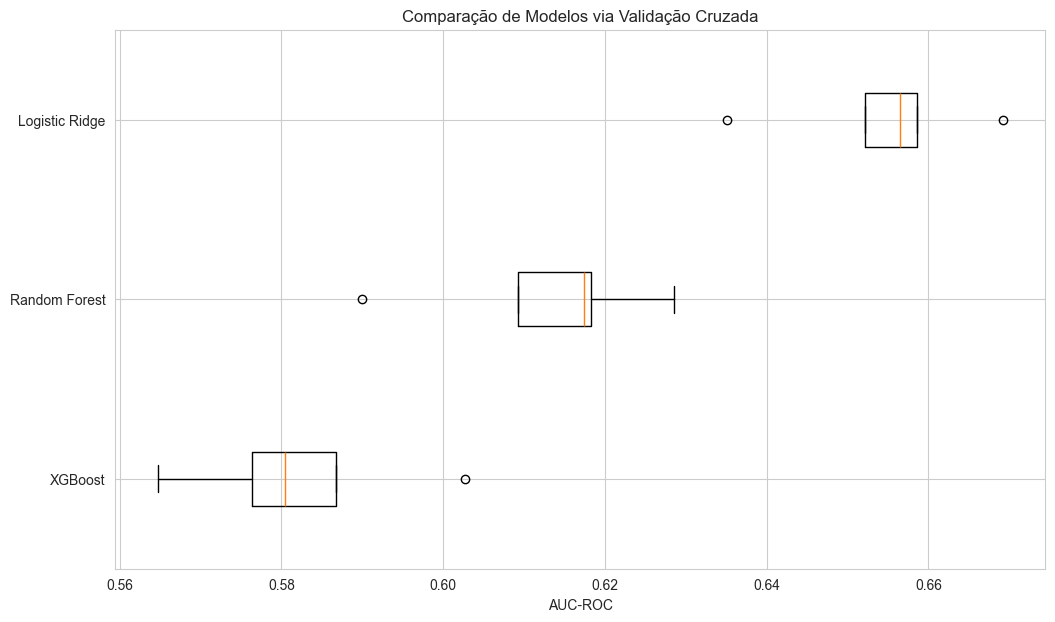

In [6]:
if 'X_final' in locals():
    X_train, X_test, y_train, y_test = train_test_split(
        X_final, y, test_size=0.2, random_state=42, stratify=y
    )

    scale_pos_weight_value = (y_train == 0).sum() / (y_train == 1).sum()

    models = {
        "Logistic Ridge": Pipeline([('model', LogisticRegression(penalty='l2', solver='liblinear', class_weight='balanced', random_state=42))]),
        "Random Forest": Pipeline([('model', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1))]),
        "XGBoost": Pipeline([('model', xgb.XGBClassifier(scale_pos_weight=scale_pos_weight_value, use_label_encoder=False, eval_metric='logloss', random_state=42))])
    }
    
    cv_results = {}
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    print("\n--- Resultados da Validação Cruzada (AUC-ROC no Treino) ---")
    for name, model in models.items():
        scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc', n_jobs=-1)
        cv_results[name] = scores
        print(f"-> {name}: Média AUC = {scores.mean():.4f} (Desvio Padrão = {scores.std():.4f})")
    
    plt.figure(figsize=(12, 7))
    sorted_results = sorted(cv_results.items(), key=lambda item: item[1].mean())
    sorted_labels = [item[0] for item in sorted_results]
    sorted_scores = [item[1] for item in sorted_results]
    plt.boxplot(sorted_scores, labels=sorted_labels, vert=False)
    plt.title('Comparação de Modelos via Validação Cruzada')
    plt.xlabel('AUC-ROC')
    plt.show()

### Análise da Competição

Olhando o gráfico acima, fica claro que o **Logistic Ridge** foi o grande vencedor da nossa competição. Ele não só teve a maior média de AUC-ROC, como também foi bem consistente nos testes (a "caixinha" dele é pequena e está mais à direita). Isso é bem interessante, porque mostra que, para este problema, um modelo mais simples e linear conseguiu extrair mais informações úteis do que os algoritmos mais complexos como Random Forest e XGBoost.

Agora que temos nosso campeão, vamos para a última etapa: o ajuste fino.

## 3) Otimização de Hiperparâmetros (Tuning)

Já sabemos que o Logistic Ridge é o melhor modelo para o nosso caso. Agora, vamos fazer um "tuning" nele. É como se a gente já tivesse escolhido o melhor carro de corrida, e agora vamos ajustar os "botões" e "alavancas" (os hiperparâmetros) dele para ver se conseguimos um desempenho ainda melhor.

Vamos focar no parâmetro `C`, que controla a "força" da regularização do modelo.

In [7]:
if 'cv_results' in locals():
    best_model_name = "Logistic Ridge"
    print(f"\nModelo selecionado para tuning: {best_model_name}")
    
    param_dist_lr = { 'model__C': np.logspace(-3, 3, 20) }

    random_search = RandomizedSearchCV(
        models[best_model_name],
        param_distributions=param_dist_lr,
        n_iter=15, scoring='roc_auc', cv=kfold,
        n_jobs=-1, random_state=42, verbose=0
    )
    
    print("Iniciando a busca de hiperparâmetros...")
    random_search.fit(X_train, y_train)
    
    print(f"\nMelhores parâmetros encontrados: {random_search.best_params_}")
    print(f"Melhor AUC na validação cruzada após tuning: {random_search.best_score_:.4f}")
    
    best_tuned_model = random_search.best_estimator_


Modelo selecionado para tuning: Logistic Ridge
Iniciando a busca de hiperparâmetros...

Melhores parâmetros encontrados: {'model__C': np.float64(0.0379269019073225)}
Melhor AUC na validação cruzada após tuning: 0.6546


### Avaliação Final do Modelo Otimizado

Chegou a hora da verdade. Vamos pegar nosso modelo campeão, o **Logistic Ridge**, já com os melhores ajustes, e colocá-lo para a prova final: o conjunto de teste. Esses são dados que o modelo nunca viu antes, então o resultado aqui é a nossa estimativa mais honesta de como ele se sairia no mundo real.


--- Avaliação Final do Modelo Otimizado (Logistic Ridge) no Conjunto de Teste ---
AUC-ROC no conjunto de teste: 0.6635

Relatório de Classificação no Teste:
              precision    recall  f1-score   support

    Classe 0       0.94      0.66      0.78      5493
    Classe 1       0.14      0.57      0.22       507

    accuracy                           0.66      6000
   macro avg       0.54      0.62      0.50      6000
weighted avg       0.88      0.66      0.73      6000



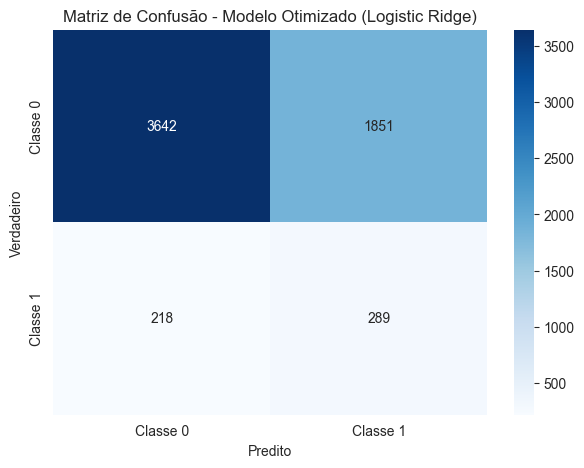

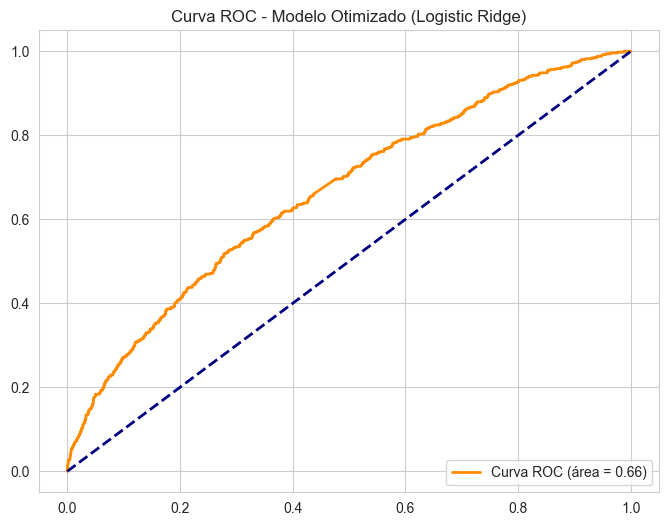

In [8]:
if 'best_tuned_model' in locals():
    best_model_name = "Logistic Ridge"
    print(f"\n--- Avaliação Final do Modelo Otimizado ({best_model_name}) no Conjunto de Teste ---")
    
    y_pred_proba = best_tuned_model.predict_proba(X_test)[:, 1]
    y_pred_class = best_tuned_model.predict(X_test)

    test_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"AUC-ROC no conjunto de teste: {test_auc:.4f}")
    print("\nRelatório de Classificação no Teste:")
    print(classification_report(y_test, y_pred_class, target_names=['Classe 0', 'Classe 1']))

    cm = confusion_matrix(y_test, y_pred_class)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
    plt.title(f'Matriz de Confusão - Modelo Otimizado ({best_model_name})')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {test_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title(f'Curva ROC - Modelo Otimizado ({best_model_name})')
    plt.legend(loc="lower right")
    plt.show()

### Conclusão Final

Bom, chegamos ao fim da nossa jornada de modelagem!

O nosso modelo final, um **Logistic Ridge** com os parâmetros otimizados, alcançou uma **AUC-ROC de 0.66** no teste final. Isso significa que ele tem um poder de discriminação razoável, sendo consideravelmente melhor do que uma escolha aleatória.

Olhando o "Relatório de Classificação", vemos algo bem interessante:
- **Recall (Classe 1) de 0.57**: Isso é ótimo! Quer dizer que, de todos os clientes que realmente são da "Classe 1" (os que mais nos interessam), nosso modelo conseguiu **encontrar 57%** deles.
- **Precisão (Classe 1) de 0.14**: Aqui está o ponto de atenção. Dos clientes que o modelo *apontou* como sendo da "Classe 1", apenas 14% realmente eram. Ele está dando alguns "alarmes falsos".

**Na prática, o que isso quer dizer?**

Temos um modelo que é bom em **identificar um grupo que contém muitos dos clientes de risco**, mesmo que traga alguns clientes bons junto. Para o negócio, isso pode ser muito útil como um sistema de **alerta precoce**. Em vez de aprovar ou negar crédito automaticamente, o modelo poderia sinalizar os clientes que ele acha que são da Classe 1 para uma análise mais detalhada por um especialista.

Em resumo, conseguimos construir, através de um processo sistemático de limpeza, seleção e otimização, um modelo com capacidade preditiva útil e com uma aplicação prática bem definida para o negócio.